In [14]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplleaflet
import geopandas as geopd
import srtm
import gpxpy
import networkx as nx
import process_gpx_data as gpx_process
import os
import shapely

from matplotlib import rc, cm
viridis = cm.get_cmap('viridis')
magma   = cm.get_cmap('magma')
plasma  = cm.get_cmap('plasma')


import autotrail as AT

m_in_mi = 1609.34
m_in_ft = 0.3048

In [2]:
#
# load the pickled traip map
#
outname = './data/boulder_area_trail_processed'
new_df, nodes, edges = gpx_process.load_trail_df(outname)
TrailMap             = gpx_process.load_graph(outname)
TrailMap.ensure_edge_attributes()

In [3]:
for k in TrailMap.edge_attributes:
    if not (k in TrailMap._weight_factors.keys()):
        TrailMap._weight_factors[k] = 0.0

In [4]:
test_coord = (-105.27818, 39.99855) # near start of chataqua

node_index, node_id = TrailMap.nearest_node( test_coord[0], test_coord[1])

In [54]:
dist          = 50.0   * m_in_mi
elev          = 3000.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist}

totals, possible_routes =\
      TrailMap.find_route(start_node, 
                          target_values, 
                          end_node=end_node)

TrailMap:  Possible and next:  [1041] [1041, 1040, 1035, 1495, 1326, 1059, 1057, 1056, 1073, 1425, 978, 971, 1021, 1018, 1016, 1014, 937, 994, 943, 946, 1000, 920, 921, 997, 1262, 10559, 12843]
TrailMap:  Picking route on way to home 33 1035 [12843, 10559, 1262, 997, 996, 1024, 1060, 1061, 1000, 946, 942, 1387, 995, 923, 1356, 1270, 1264, 956, 954, 1091, 1093, 1389, 1381, 1339, 1338, 1274, 1076, 1376, 1350, 1351, 1008, 1009, 1034, 1035]
TrailMap:  Possible and next:  [1041, 1040, 1035, 1495, 1326, 1059, 1057, 1056, 1073, 1425, 978, 971, 1021, 1018, 1016, 1014, 937, 994, 943, 946, 1000, 920, 921, 997, 1262, 10559, 12843] [12843, 10559, 1262, 997, 996, 1024, 1060, 1061, 1000, 946, 942, 1387, 995, 923, 1356, 1270, 1264, 956, 954, 1091, 1093, 1389, 1381, 1339, 1338, 1274, 1076, 1376, 1350, 1351, 1008, 1009, 1034, 1035]
TrailMap:  Picking route on way to home 0 1035 [1035]
TrailMap:  Possible and next:  [1041, 1040, 1035, 1495, 1326, 1059, 1057, 1056, 1073, 1425, 978, 971, 1021, 1018, 1016,

In [47]:
totals[0]['distance'] / m_in_mi

20.779264160893355

In [50]:
possible_routes[0]

[1041,
 1040,
 1035,
 1034,
 1009,
 1008,
 1351,
 1350,
 1376,
 1076,
 1274,
 1338,
 1339,
 1381,
 1389,
 1093,
 1396,
 1399,
 1398,
 1444,
 1449,
 1106,
 1439,
 1288,
 1047,
 973,
 972,
 906,
 907,
 1175,
 1354,
 1006,
 904,
 905,
 904,
 907,
 906,
 972,
 809,
 973,
 1047,
 1291,
 1288,
 1439,
 1106,
 1449,
 1444,
 1398,
 1399,
 953,
 952,
 954,
 956,
 1264,
 1270,
 1021,
 971,
 978,
 1425,
 1073,
 1056,
 1057,
 1059,
 1326,
 1495,
 1035,
 1038,
 1040,
 1041]

In [48]:
def plot(graph, node_order=None,
         weight='distance', zoom =True,
         region = None):
    
    #pos = nx.spring_layout(graph, weight=weight, seed = 12345)
    
    
    pos = {ni : np.array([n['long'],n['lat']]) for ni,n in graph.nodes(data=True)}
    
    pc = nx.draw_networkx_nodes(graph, pos, node_size=20)
    ax = pc.figure.axes[0]

    pc.figure.set_size_inches(8,8)

    #edges = [(u,v)]
    etraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] > 0]
    enottraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] == 0]

    colors = 'black'
    if not (node_order is None):
        ecolor_int = [node_order.index(e[0]) for e in etraveled]
        #colors = magma((np.array(ecolor_int)+5) / ((1.0*len(node_order)+5)))
        colors = ["C%i"%i for i in ecolor_int]
        
    temp = nx.draw_networkx_edges(graph, pos, edgelist=etraveled, width=2, edge_color=colors)
    temp = nx.draw_networkx_edges(graph, pos, edgelist=enottraveled, width=2, style='dashed')
    
    

    travelled_edges = graph.edges_from_nodes(node_order)
    travelled_edges_counter = {x : 0 for x in np.unique(travelled_edges)}
    
    edge_labels = {}
    count = 0
    for (u,v,d) in graph.edges(data=True):
        
        if not((u,v) in edge_labels.keys()):
            edge_labels[(u,v)] = ''
    
    count = 1
    for (u,v) in travelled_edges:
        try:
            edge_labels[(u,v)] = edge_labels[(u,v)] + '%i '%(count)
        except:
            edge_labels[(v,u)] = edge_labels[(v,u)] + '%i '%(count)
            
        count = count + 1

    #try:
    #    edge_labels = { (u,v) : "%i"%(d['ShapeLen']) for (u,v,d) in graph.edges(data=True)}
    #except:    
    #    edge_labels = { (u,v) : "%i"%(d['SHAPESTLength']) for (u,v,d) in graph.edges(data=True)}
    temp = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.5)
    
    #temp = nx.draw_networkx_labels(graph, pos, labels={n:n for n,data in graph.nodes(data=True)}, font_size=17,
    #                        font_color = 'black')
    
    
    chataqua = (-105.2795, 39.9972)
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 200)


    sep = 0.025
    if zoom:
        ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
        ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
        
    #print(pos)
    return pc,ax

<IPython.core.display.Javascript object>


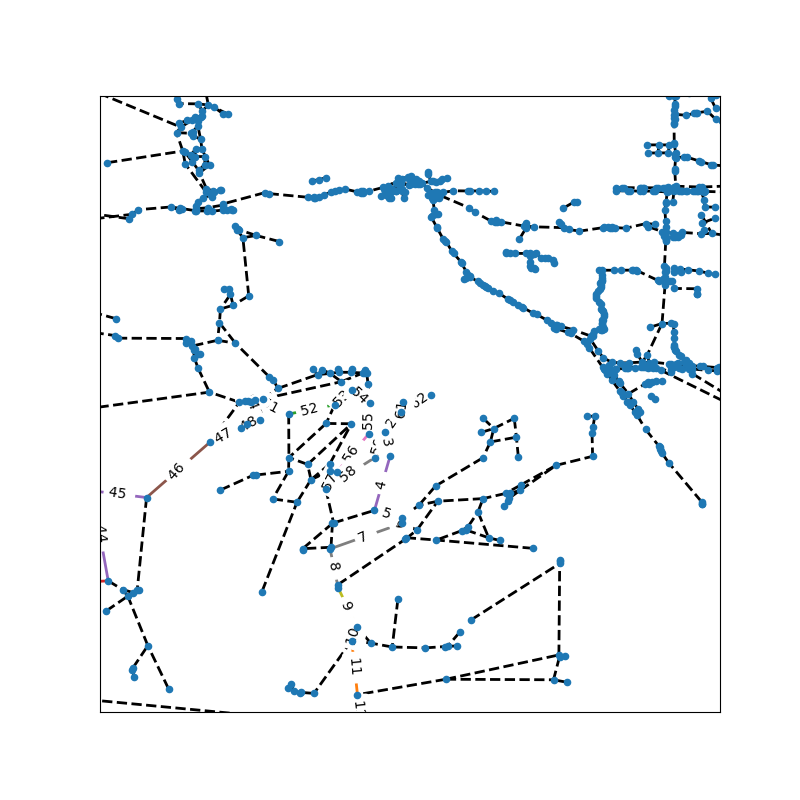

(<matplotlib.collections.PathCollection at 0x7fad8abddc10>, <AxesSubplot:>)

In [55]:
plot(TrailMap,node_order=possible_routes[0])

In [37]:
x = TrailMap.edges_from_nodes(possible_routes[0])
print(x)

[(1041, 1040), (1040, 1035), (1035, 1495), (1495, 1326), (1326, 1059), (1059, 1057), (1057, 1056), (1056, 926), (926, 967), (967, 1011), (1011, 1009), (1009, 1034), (1034, 1035), (1035, 1038), (1038, 1040), (1040, 1041)]


In [38]:
(1040,1035) in x

True

In [39]:
(1040,0) in x

False